In [1]:
#load in necessary packages
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sns

In [2]:
df = pd.read_csv('multiclass.csv')

In [3]:
df.head()

,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR","personnelO_2 RB, 0 TE, 3 WR","personnelO_2 RB, 1 TE, 2 WR",...,"personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed
0,5.545260,1.012640,33,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0
1,5.431814,1.012640,33,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0
2,3.869395,0.991871,33,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0
3,3.013485,0.991871,33,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0
4,2.924474,0.963247,33,2.253908,53504.0,1.348332,42404.0,4.608188,25511.0,3.021523,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0


In [4]:
df['OL_success'] = df.apply(lambda x: 1 if (x.pff_beatenByDefender != 1 or x.pff_hitAllowed != 1 or x.pff_hurryAllowed != 1 or x.pff_sackAllowed !=1) else 0, axis = 1)

In [5]:
#dummy columns to be encoded
y = df[['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed', 'OL_success']]

In [6]:
#encode y into one column
# Find the index of the max value in each row of the dummy variables dataframe
encoded_labels = y.idxmax(axis=1)
df['encoded_column'] = encoded_labels
df.encoded_column.head()

0    pff_hurryAllowed
1    pff_hurryAllowed
2    pff_hurryAllowed
3    pff_hurryAllowed
4    pff_hurryAllowed
Name: encoded_column, dtype: object

In [7]:
df.encoded_column.unique()

array(['pff_hurryAllowed', 'OL_success', 'pff_beatenByDefender',
       'pff_sackAllowed', 'pff_hitAllowed'], dtype=object)

OL_success              1505099
pff_hurryAllowed          81708
pff_beatenByDefender      64069
pff_hitAllowed            17879
pff_sackAllowed           15011
Name: encoded_column, dtype: int64


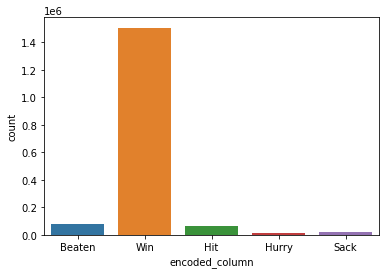

In [8]:
#plot
print(df.encoded_column.value_counts())
class_names = [ 'Beaten','Win', 'Hit', 'Hurry',
       'Sack']
ax = sns.countplot(x=df.encoded_column); 
ax.set_xticklabels(class_names)
plt.show()

In [9]:
# Divide by class
df_class_0    = df[df.encoded_column == 'OL_success'] #class with more samples
df_class_1    = df[df.encoded_column == 'pff_beatenByDefender'] #class with more samples
df_class_2    = df[df.encoded_column == 'pff_hurryAllowed'] #class with more samples
df_class_3    = df[df.encoded_column == 'pff_hitAllowed'] #class with more samples
df_class_4    = df[df.encoded_column == 'pff_sackAllowed'] #class with fewer samples
count_class_4 = len(df_class_4)

Random Under-Sampling:
OL_success              15011
pff_beatenByDefender    15011
pff_hurryAllowed        15011
pff_sackAllowed         15011
pff_hitAllowed          15011
Name: encoded_column, dtype: int64


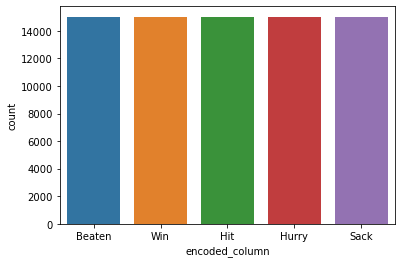

In [10]:
df_class_0_under = df_class_0.sample(count_class_4, replace=True)
df_class_1_under = df_class_1.sample(count_class_4, replace=True)
df_class_2_under = df_class_2.sample(count_class_4, replace=True)
df_class_3_under = df_class_3.sample(count_class_4, replace=True)
df_new = pd.concat([df_class_0_under, df_class_1_under], axis=0) 
df_new = pd.concat([df_new, df_class_2_under], axis=0)
df_new = pd.concat([df_new, df_class_3_under], axis=0)
df_under         = pd.concat([df_new, df_class_4], axis=0)
print('Random Under-Sampling:')
print(df_under.encoded_column.value_counts())
#plot
ax = sns.countplot(x=df_under.encoded_column); 
ax.set_xticklabels(class_names)
plt.show()

In [11]:
X = df_under.drop(['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed', 'OL_success', 'encoded_column'], axis = 1)
y = df_under['encoded_column']

In [12]:
#encode y-values
le = preprocessing.LabelEncoder()
le.fit(y)
classes = le.classes_
y=le.transform(y)
le.classes_

array(['OL_success', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed'], dtype=object)

In [13]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
class_names = [ 'Win', 'Beaten', 'Hit', 'Hurry','Sack']

In [15]:
# param_grid = {
#     "criterion":["gini","entropy"], #gini or Entropy
#     "n_estimators": [100,150,200],
#     "min_samples_split":([2,5]),
#     "max_features": ['sqrt', 5],
# }
# #Random forest classifier
# clf = RandomForestClassifier(random_state=0)
# grid = GridSearchCV(estimator=clf, param_grid = param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
# grid.fit(X_tr, y_tr)
# best_params = grid.best_params_
# print(f"Best paramters: {best_params})")
# #make confusion matrix
# clf = RandomForestClassifier(**best_params,random_state=0)
# clf.fit(X_tr, y_tr)
# y_pred = clf.predict(X_te)
# #
# acc = accuracy_score(y_te, y_pred)
# cm = confusion_matrix(y_te, y_pred)
# #plot
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
# cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
# cmd.plot(ax=axes[0])
# axes[0].set_title('counts')
# cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
# cmd.plot(ax=axes[1])
# axes[1].set_title('normalized')
# fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16); #Best paramters: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 200})

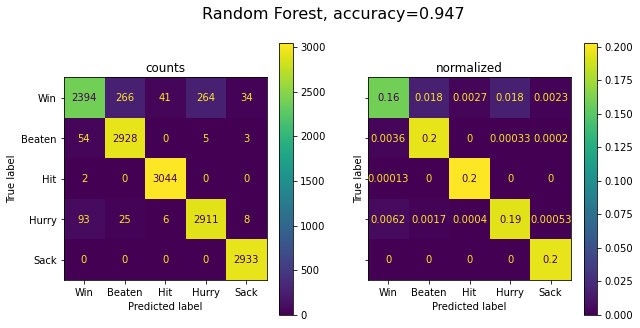

In [16]:
#Random forest classifier
clf = RandomForestClassifier(criterion = 'gini', max_features = 5, min_samples_split = 2, n_estimators=200 ,random_state=0)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);

In [17]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      2999
           1       0.91      0.98      0.94      2990
           2       0.98      1.00      0.99      3046
           3       0.92      0.96      0.94      3043
           4       0.98      1.00      0.99      2933

    accuracy                           0.95     15011
   macro avg       0.95      0.95      0.95     15011
weighted avg       0.95      0.95      0.95     15011



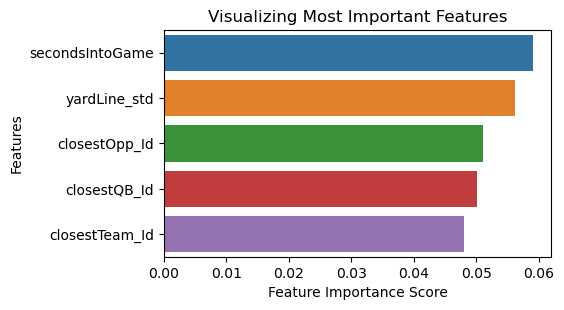

In [18]:
#view feature importance
features = X.columns.tolist()
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False).head(5)
# Creating a bar plot
fig, ax = plt.subplots(figsize=(5, 3),dpi= 100)  #original shape was 8.1, 10
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Most Important Features")
plt.show()

### Apply model to full sample

In [19]:
df.head()

,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR","personnelO_2 RB, 0 TE, 3 WR","personnelO_2 RB, 1 TE, 2 WR",...,"personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,OL_success,encoded_column
0,5.545260,1.012640,33,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,pff_hurryAllowed
1,5.431814,1.012640,33,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,pff_hurryAllowed
2,3.869395,0.991871,33,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,pff_hurryAllowed
3,3.013485,0.991871,33,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,pff_hurryAllowed
4,2.924474,0.963247,33,2.253908,53504.0,1.348332,42404.0,4.608188,25511.0,3.021523,87,0.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,pff_hurryAllowed


In [20]:
X = df.drop(['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed', 'OL_success', 'encoded_column'], axis = 1)
y = df['encoded_column']

In [21]:
#encode y-values
le = preprocessing.LabelEncoder()
le.fit(y)
classes = le.classes_
y=le.transform(y)
le.classes_

array(['OL_success', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed'], dtype=object)

In [22]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

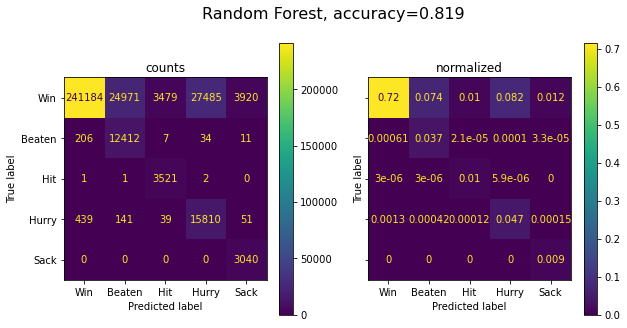

In [23]:
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);

In [24]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89    301039
           1       0.33      0.98      0.49     12670
           2       0.50      1.00      0.67      3525
           3       0.36      0.96      0.53     16480
           4       0.43      1.00      0.60      3040

    accuracy                           0.82    336754
   macro avg       0.53      0.95      0.64    336754
weighted avg       0.93      0.82      0.85    336754

